<a href="https://colab.research.google.com/github/chaiwencw/CPO-Price-Forecasting-Using-Simulated-Annealing-based-Support-Vector-Regression/blob/main/SA-SVR%20in%20CPO%20Price%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Import Packages

In [ ]:
# uncomment the code below to install the plotly package if it is not detected in the current environment
# pip install plotly 

In [ ]:
import pandas as pd                                   # to deal with pandas dataframe
import numpy as np                                    # to deal with numbers
import datetime as dt                                 # to deal with datetime data
import time                                           # to record execution time
import seaborn as sns                                 # to plot graphs
import plotly.graph_objects as go                     # to plot graphs
from matplotlib import pyplot as plt                  # to plot graphs
from statsmodels.graphics import tsaplots             # to plot graphs
from sklearn.preprocessing import PowerTransformer    # to make data more Gaussian-like
from sklearn.model_selection import train_test_split  # to split data arrays into two subsets
from SA_parameter_optimization import *               # import all (methods, variables...) from SA_parameter_optimization

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Section 1: Data Pre-processing
This section shows importing necessary packages, and data importation and cleaning.

## Section 1.1: Import Data


In [ ]:
data = pd.read_excel('FYP_Data.xlsx', na_values='-')            # read FCPO dataset
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")  # convert Date column to datatime format
data.head()                                                     # show the first 5 rows of the data for review

,Date,Open,Close,High,Low,Volume,Percentage Change
0,2012-01-03,555.9,558.37371,560.9,548.1,1440.0,0.009900
1,2012-01-04,555.2,550.02400,559.2,548.7,1320.0,-0.014954
2,2012-01-05,554.0,545.21500,555.9,543.7,930.0,-0.008743
3,2012-01-06,543.3,544.60028,546.2,539.2,780.0,-0.001127
4,2012-01-07,540.0,536.70330,540.7,534.3,600.0,-0.014501


* Open: Price when the market begin
* Close: Price when the market closed
* High: Highest price reached during that day
* Low: Lowest price traded on that day
* Volume: Total amount traded on that day
* Percentage Change: 

## Section 1.2: Data Cleaning

In [ ]:
data.info()                                                     # print information summary of the dataset 
null = data.isnull().sum()                                      # find the total no. of missing values in each column
df_null = pd.DataFrame(data = null, columns = ['No. of Null'])  # create a dataframe to show the number of null
print('\n\n', df_null)                                          # number of null in each column is shown
print(f'\n\nThe total no. of null is  {sum(null)}')             # the total number of null is shown

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2788 entries, 0 to 2787
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2788 non-null   datetime64[ns]
 1   Open               2788 non-null   float64       
 2   Close              2788 non-null   float64       
 3   High               2788 non-null   float64       
 4   Low                2788 non-null   float64       
 5   Volume             2743 non-null   float64       
 6   Percentage Change  2788 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 152.6 KB


                    No. of Null
Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                      45
Percentage Change            0


The total no. of null is  45


In [ ]:
data_cleaned = data.dropna()  # drop all missing values
data_cleaned.info()           # check the dataset information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2743 entries, 0 to 2787
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2743 non-null   datetime64[ns]
 1   Open               2743 non-null   float64       
 2   Close              2743 non-null   float64       
 3   High               2743 non-null   float64       
 4   Low                2743 non-null   float64       
 5   Volume             2743 non-null   float64       
 6   Percentage Change  2743 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 171.4 KB


# Section 2: Exploratory Data Analysis




## Section 2.1: Descriptive Statistics

In [ ]:
# Determine the summary statistics of data_cleaned (by default numerical columns)
data_cleaned.describe()


In [ ]:
# Determine the summary statistics of the date column
data_cleaned.Date.describe()

In [ ]:
# Determine the minimum, maximum, average and standard deviation of each numerical column in each year
for col in data_cleaned.select_dtypes(exclude=['datetime64[ns]']).columns:
  desc_stat = data_cleaned.groupby(data_cleaned.Date.dt.year)[[col]].agg
  (['min','max','mean','std'])
  print(f'\nDescriptive Statistics of:{desc_stat}')
  print("\n")

From the descriptive statistics, one can see a sharp increase of CPO price in 2021. 

##Section 2.2: Data Visualization

In [ ]:
# candlestick plot (with range slider)
fig = go.Figure(data=[go.Candlestick(x=data_cleaned['Date'],
                open=data_cleaned['Open'],
                high=data_cleaned['High'],
                low=data_cleaned['Low'],
                close=data_cleaned['Close'],
                increasing_line_color= 'green', 
                decreasing_line_color= 'red')])
fig.update_yaxes(autorange = True,fixedrange=False)   # add this line for y-axis rescaling
fig.show()

The above shows the candlestick plot of CPO historical price with a range slider. To observe the price change, we can zoom in by simply dragging the handles of the range slider. When x-range (date) changes, we can manually rescale the y-axis.

In [ ]:
# Plot the actual close price and its rolling mean over certain number of previous periods
plt.figure(figsize = (15,3))
plt.plot(data_cleaned['Date'], data_cleaned['Close'],label='Close')
plt.legend(loc=0)
plt.title('CPO Historical Close Price')
plt.show()

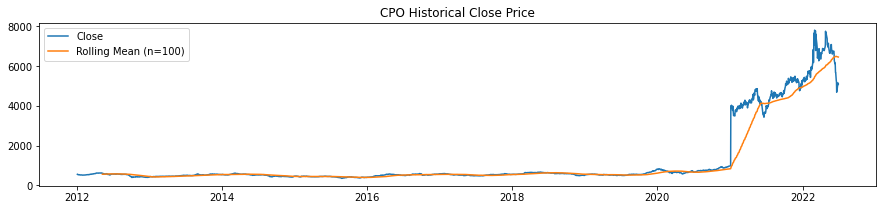

In [ ]:
# plot the actual close price and its rolling mean over certain number of previous periods
plt.figure(figsize = (15,3))
plt.plot(data_cleaned['Date'], data_cleaned['Close'],label='Close')
plt.plot(data_cleaned['Date'],data_cleaned['Close'].rolling(100).mean(),label='Rolling Mean (n=100)')
# plt.plot(data_cleaned['Date'],data_cleaned['Close'].rolling(200).mean(),label='Rolling Mean (n=200)')
plt.legend(loc=0)
plt.title('CPO Historical Close Price')
plt.show()

The rolling mean plot here is the average prices over a defined number of previous periods (last 'n' values) in a time series. It helps us detect CPO close price trends and notice the peak more easily and evidently. The plot above clearly shows the sudden surge in CPO price in 2021.

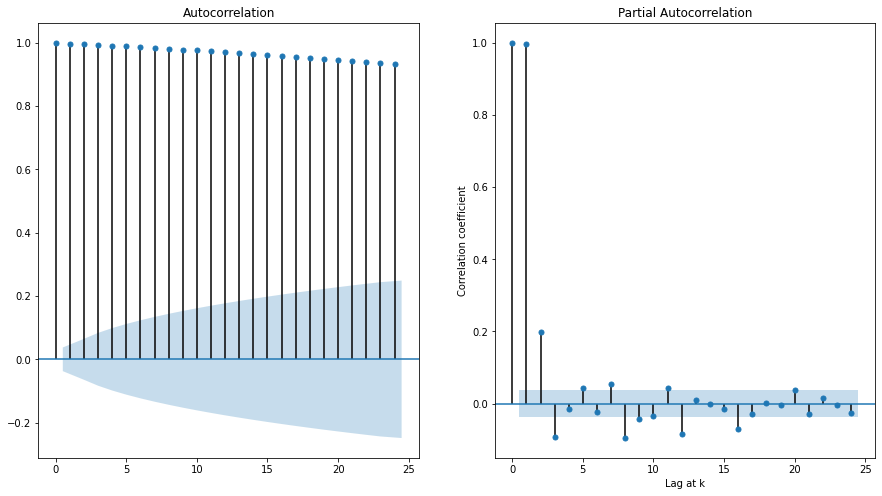

In [ ]:
fig, ax= plt.subplots(1,2, figsize=(15,8))
# Autocorrelation plot
tsaplots.plot_acf(data_cleaned['Close'], lags=24, alpha=0.05, ax=ax[0])
# Partial autocorrelation plot
tsaplots.plot_pacf(data_cleaned['Close'], lags=24,  alpha=0.05, ax=ax[1])
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

PCAF-preliminarily identify appropriate lag structure
-> from the plot, we find the time-lag value. From the plot above, lag 1 is prominent and above confidence level -> the correlation at lag 1 is significant and positive.


# Section 3.0  Feature Engineering & Data Splitting & Tranformation

## Section 3.1 Lag Features

In [ ]:
# create lag features: previous day open, high, low, close prices & volume & percentage change 
new_data = data_cleaned.copy()
for col in new_data.drop({"Open",'Date','Close'}, axis=1).columns:
  new_data[f'Prev_{col}'] = new_data[col].shift(periods=1)
  new_data = new_data.drop(columns = col, axis=1) 

In [ ]:
# remove first row of dataset
new_data = new_data.iloc[1:,:] 

## Section 3.2 Date-Related Features

In [ ]:
# extract year, month, day etc. from Date
newdate = new_data['Date']
exact_trading_date = pd.DataFrame({'Year': newdate.dt.year,
                                    'Month': newdate.dt.month,
                                    'Day': newdate.dt.day,
                                    'Day_of_Year': newdate.dt.dayofyear,
                                    'Week_of_Year': newdate.dt.isocalendar().week,
                                    'Day_of_Week': newdate.dt.isocalendar().day,
                                    'Weekday': newdate.dt.weekday,
                                    'Quarter': newdate.dt.quarter,
                                    })
new_data = pd.concat([exact_trading_date, new_data], axis = 1)
new_data = new_data.set_index('Date')
new_data.head()

,Year,Month,Day,Day_of_Year,Week_of_Year,Day_of_Week,Weekday,Quarter,Close,Prev_Open,Prev_High,Prev_Low,Prev_Volume,Prev_Percentage Change
Date,,,,,,,,,,,,,,
2012-01-04,2012,1,4,4,1,3,2,1,550.02400,555.9,560.9,548.1,1440.0,0.009900
2012-01-05,2012,1,5,5,1,4,3,1,545.21500,555.2,559.2,548.7,1320.0,-0.014954
2012-01-06,2012,1,6,6,1,5,4,1,544.60028,554.0,555.9,543.7,930.0,-0.008743
2012-01-07,2012,1,7,7,1,6,5,1,536.70330,543.3,546.2,539.2,780.0,-0.001127
2012-01-09,2012,1,9,9,2,1,0,1,542.12067,540.0,540.7,534.3,600.0,-0.014501


## Section 3.3 Data Splitting & Transformation

In [ ]:
# specify feature columns and the target
features = new_data.drop(columns = ['Close'])
target = np.array(new_data['Close'])

In [ ]:
# split the dataset into two subsets: training set & test set 
target = target.reshape(len(target), 1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.30, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1919, 13), (823, 13), (1919, 1), (823, 1))

In [ ]:
# save the date in test set (for time series plot after predictions)
time_index = x_test.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train)
scalerY = PowerTransformer().fit(y_train)

# producing a series with transformed values that has the same axis length.
x_train = scalerX.transform(x_train)
y_train = scalerY.transform(y_train)
x_test = scalerX.transform(x_test)
y_test = scalerY.transform(y_test)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train = np.ravel(y_train) 
y_test = np.ravel(y_test)

# Section 4: Analysis

## Section 4.1: 

In [ ]:
# parameters that are kept constant during the tuning process
const_param = {}
const_param['kernel'] = 'rbf' # use rbf kernel for svr model

In [ ]:
# parameter search space
param_dict = {}
param_dict['C'] = tuple(np.arange(10.0**5, 10.0**6 + 1))      # the larger the better 
param_dict['gamma'] = tuple(10**-x  for x in range(2, 21))    # max. python can accept is 32, where only these are larger than 0
param_dict['epsilon'] = tuple(10**-x  for x in range(2, 21))  # float - small; smallest can get is 1E-32

In [ ]:
# define the inputs for SA
SA_parameters = {
    "param_dict": param_dict,
    "constant_params": const_param, 
    "X_train": x_train,
    "Y_train": y_train, 
    "X_valid": x_test,
    "Y_valid": y_test, 
    "no_iters": 20,
    "alpha": 0.75,
    "initial_temperature": 100,
    "min_temperature": 30,
}

In [ ]:
# run the simulated annealing function (in SA_parameter_optimization.py) to obtain the best solution;
# both starting and ending time are recorded to calculate execution time
start_time = time.time()
best_model, result, total_iter = simulate_annealing(**SA_parameters)
end_time = time.time()

Current Temperature is: 100.00


Starting Iteration 1
Local Improvement in metric from 5960.107932 to 4527.772208  - parameters accepted

Global Improvement in metric from 5960.107932 to 4527.772208  - best parameters updated




Starting Iteration 2
Local Improvement in metric from 4527.772208 to 21.195499  - parameters accepted

Global Improvement in metric from 4527.772208 to 21.195499  - best parameters updated




Starting Iteration 3
No Improvement and parameters are REJECTED.
Metric change:   5903.024188
Threshold:       0.000000
Random Number:   0.684830




Starting Iteration 4
Local Improvement in metric from 21.195499 to 15.577541  - parameters accepted

Global Improvement in metric from 21.195499 to 15.577541  - best parameters updated




Starting Iteration 5
Combination revisited.





Starting Iteration 6
No Improvement and parameters are REJECTED.
Metric change:   2519.986147
Threshold:       0.000000
Random Number:   0.059678




Starting Iteration 7
Local Improvement 

In [ ]:
# the diffence between starting and ending time need to be converted to struct_time object;
# so, strftime() function can be used to format the execution time
time_difference = time.gmtime(end_time - start_time)
formatted_time = time.strftime("%H hours %M minutes %S seconds", time_difference)
print(f'Execution time: {formatted_time}.')

Execution time: 00 hours 01 minutes 32 seconds.


## Section 4.2:

In [ ]:
# print the best combination of hyperparameters and the best metric
# pd.options.display.float_format = '{:.3e}'.format
best_parameters = result[result["Metric"] == result['Best Metric'].min()]
best_parameters

,Number of Temperature Reduction,C,gamma,epsilon,Metric,Best Metric
8,0,508125.0,0.0,0.0,12.29415,12.29415


In [ ]:
# print the result of each time a temperature is completed 
result

,Number of Temperature Reduction,C,gamma,epsilon,Metric,Best Metric
0,0,377869.0,0.0001,0.0001,4527.772208,4527.772208
1,0,377869.0,0.0,0.0001,21.195499,21.195499
2,0,377869.0,0.0,0.0001,5924.219688,21.195499
3,0,377869.0,0.0,0.0,15.577541,15.577541
4,0,377869.0,0.0,0.0,15.577541,15.577541
...,...,...,...,...,...,...
15,4,604075.0,0.0,0.0,39.069179,12.29415
16,4,604075.0,0.0,0.0,30.145007,12.29415
17,4,604075.0,0.0,0.0,2035.771789,12.29415
18,4,604075.0,0.0,0.0,24.545399,12.29415


In [ ]:
# print the regression metrics of the fine-tuned SVR
preds = best_model.predict(x_test)
RegressionMetric(y_test, preds)

MAE:  1.579038152095821
MAPE: 0.3876962775066566
RMSE: 3.5063015251509766
r2: 0.9964198737973428


In [ ]:
# print the regression metrics of the SVR model without hyperparameter optimization (default parameter values are set)
t_model, _ = model_training(x_train, y_train, x_test, y_test)
predict = t_model.predict(x_test)
RegressionMetric(y_test, predict)

MAE:  49.78852397122826
MAPE: 0.8711891753525102
RMSE: 77.20173529398211
r2: -0.7356171765242863


In [ ]:
# back tranform the data
transformed_ytest = y_test.reshape(len(y_test), 1)            # reshape the transformed close price in test set
ori_ytest = scalerY.inverse_transform(transformed_ytest)      # transform it back to the actual value 
transformed_preds = preds.reshape(len(preds), 1)              # reshape the transformed predicted close price
ori_preds = scalerY.inverse_transform(transformed_preds)      # tranform it back to the actual value
df = pd.DataFrame({'Actual Close': ori_ytest[:, 0],           # create the data frame with the actual and predicted close price
                   'Prediction': ori_preds[:, 0]})            
df = pd.concat([time_index, df], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df

,Actual Close,Prediction
Date,,
2019-03-04,554.68416,560.981945
2019-03-05,549.37488,555.400461
2019-03-06,547.80674,555.483933
2019-03-07,541.22640,551.284198
2019-03-08,538.00692,547.342966
...,...,...
2022-06-24,4798.00000,4746.933767
2022-06-27,5049.00000,4827.097177
2022-06-28,5159.00000,4928.737261


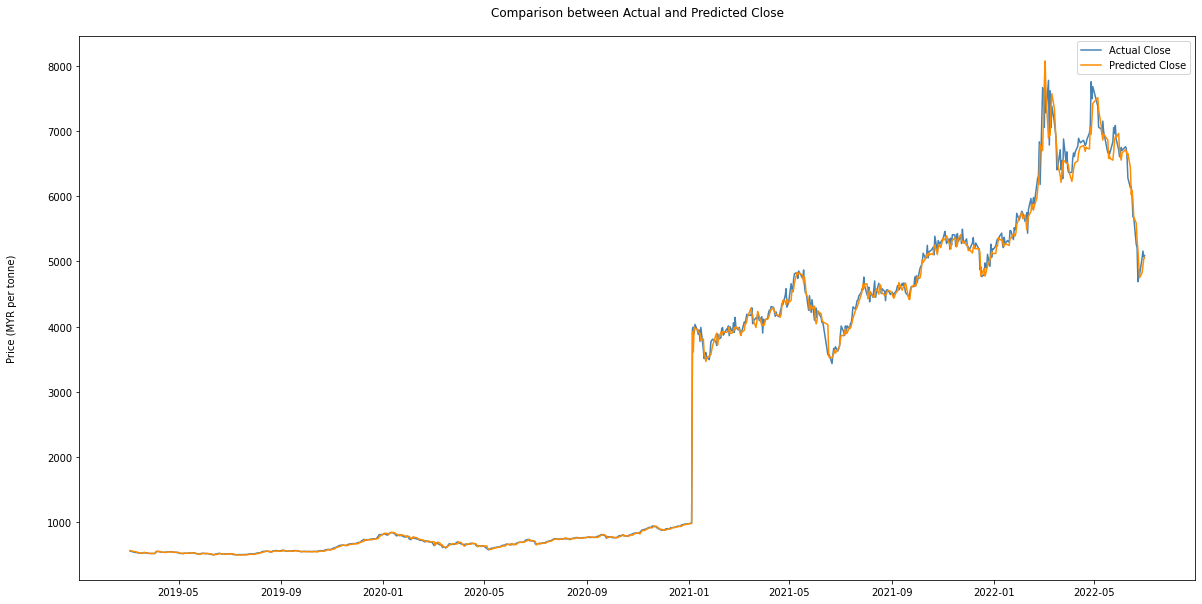

In [ ]:
# visualize the actual and predicted close price
plt.figure(figsize=(20, 10))
plt.plot(df['Actual Close'],label='Actual Close',color='steelblue')
plt.plot(df['Prediction'], label='Predicted Close',color='darkorange')
plt.title('Comparison between Actual and Predicted Close', pad = 20)
plt.ylabel('Price (MYR per tonne)', rotation = 90, labelpad = 30)
plt.legend(loc=0)
plt.show()

## Section 4.3:

In [ ]:
iterations = np.arange(total_iter) + 1
result.insert(0, "Number of Iterations", iterations)
result.to_csv("result.csv", index = False)